In [ ]:
# Install adjustText
try: 
    import adjustText
except ModuleNotFoundError:
    import sys
    !{sys.executable} -m pip install adjustText
    import adjustText

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from scipy import stats
from ast import literal_eval
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
import matplotlib.lines as mlines
from matplotlib import gridspec

# SET PATH
PATH = "../data"

# Load Freq Matrices


In [ ]:
freq_matrix_cats = pd.read_csv(f"{PATH}/freq_matrix_cats.csv", index_col = 0)
print(f"Categories Freq Matix Shape: {freq_matrix_cats.shape}")
freq_matrix_cats.head(5)

Categories Freq Matix Shape: (255093, 727)


,accountant,activist,actor,actress,administrator,ambassador,analyst,animal trainer,animator,announcer,anthropologist,archbishop,architect,arranger,art director,art teacher,art therapist,artist,assemblyman,assistant,assistant coach,assistant director,assistant editor,assistant manager,assistant minister,assistant pastor,assistant principal,assistant professor,assistant secretary,assistant supervisor,assistant teacher,attorney,auditor,author,babysitter,bachelor,baker,bank teller,banker,bar attendant,...,team manager,technical engineer,technician,technologist,teller,therapist,toxicologist,tracer,trader,trainer,translator,transportation engineer,transportation inspector,travel agent,treasurer,truck driver,tutor,usher,utility worker,van driver,vendor,veterinarian,vice chairman,vice president,video editor,waiter,waitress,warden,warehouse supervisor,wash helper,wash operator,web designer,webmaster,window cleaner,wrestler,writer,writer consultant,yard inspector,yard manager,yard worker
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
freq_matrix_names = pd.read_csv(f"{PATH}/freq_matrix_names.csv", index_col = 0)
print(f"Names Freq Matrix Shape: {freq_matrix_names.shape}")
freq_matrix_names.head(5)

Names Freq Matrix Shape: (270320, 855)


,accountant,activist,activist director,activist leader,actor,actress,administrator,advertising manager,ambassador,analyst,animal trainer,animator,announcer,anthropologist,archaeologist,architect,arranger,art dealer,art director,art teacher,artist,assistant,assistant assistant,assistant assistant coach,assistant attorney,assistant attorney general,assistant chef,assistant coach,assistant commissioner,assistant cook,assistant dean,assistant director,assistant doctor,assistant editor,assistant general counsel,assistant lawyer,assistant manager,assistant managing director,assistant nurse,assistant principal,...,technician,technician\n\npilot,technologist,tennis player,tester,theologian,therapist,ticketer,tier,tier analyst,toxicologist,trader,trainer,translator,translator writer,transportation engineer,travel agent,treasurer,treasury secretary,truck driver,tutor,tv star,usher,vendor,veterinarian,vice president,video editor,violinist,voice actor,waiter,waitress,web designer,web developer,web-designer,webmaster,wrangler,wrapper,wrapper wrapper,wrestler,writer
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Output Tables

## Top Jobs for Each Category with Row-Wise Proportions

In [ ]:
# Make row-wise sum
def row_wise_props(df):
  '''Converts counts to row-wise proportions'''
  df["sum"] = df.sum(axis=1)
  df_props = df.div(df['sum'], axis = 0)
  df_props = df_props.drop("sum", axis = 1)
  return df_props

def top_jobs_table(freq_matrix_cats, gender):
  '''Generates table for top 5 names per category for GPT predictions'''
  df = freq_matrix_cats.groupby(['category', 'gender']).aggregate(sum).astype(int)
  df = df.reset_index()
  df_gender = df[df['gender'] == gender]
  df_gender = df_gender.drop('gender', axis =1).set_index('category')
  df_row = row_wise_props(df_gender)
  x=pd.DataFrame(df_row).T
  cats = []
  results = {}
  for i in x.columns:
    results_i = {}
    df1row = x.nlargest(5, i)
    df1row = (df1row[i].astype('float64').round(2))
    props = df1row.to_list()
    index_list  = df1row.index.to_list()
    jobs = [s.replace('.1', '') for s in index_list]
    cats.append(i)
    tuple_list = []
    for job, prop in zip(jobs, props):
      job_tuple = f'{job} ({prop})'
      tuple_list.append(job_tuple)
    results_i['GPT'] = tuple_list
    results_i['Sum_Props'] = sum(props)
    results[i] = results_i
  results_df = pd.DataFrame.from_dict(results, orient = 'index')
  return results_df

In [ ]:
# Export Woman Jobs
woman_jobs_cats = top_jobs_table(freq_matrix_cats, 'F')
woman_jobs_names = top_jobs_table(freq_matrix_names, 'F')
woman_jobs = pd.concat([woman_jobs_cats, woman_jobs_names])
# woman_jobs.to_csv('./data/woman_jobs.csv')

In [ ]:
#Export Man Jobs
man_jobs_cats = top_jobs_table(freq_matrix_cats, 'M')
man_jobs_names = top_jobs_table(freq_matrix_names, 'M')
man_jobs = pd.concat([man_jobs_cats, man_jobs_names])
# man_jobs.to_csv("./data/man_jobs.csv")

## Row-Wise US data

In [ ]:
# Load US Data
us_props = pd.read_csv(f"{PATH}/us_rowwise_data.csv")

In [ ]:
def top_five_table_US(us_props, gender):
  '''Generates table for top 5 names per category for US'''
  df_gender = us_props[us_props['gender'] == gender]
  df_gender = df_gender.drop('gender', axis =1).set_index('category')
  x=pd.DataFrame(df_gender).T
  cats = []
  results = {}
  for i in x.columns:
    results_i = {}
    df1row = x.nlargest(5, i)
    df1row = (df1row[i].astype('float64').round(2))
    props = df1row.to_list()
    index_list  = df1row.index.to_list()
    jobs = [s.replace('.1', '') for s in index_list]
    cats.append(i)
    tuple_list = []
    for job, prop in zip(jobs, props):
      job_tuple = f'{job} ({prop})'
      tuple_list.append(job_tuple)
    results_i['US Data'] = tuple_list
    results_i['Sum_Props'] = sum(props)
    results[i] = results_i
  return pd.DataFrame.from_dict(results, orient = 'index')

In [ ]:
# Export Woman Job
woman_jobs_US = top_five_table_US(us_props, 'F')
# woman_jobs_US.to_csv("./data/woman_jobs_US.csv")

In [ ]:
# Export Man Jobs
man_jobs_US = top_five_table_US(us_props, 'M')
# man_jobs_US.to_csv("./data/man_jobs_US.csv")

## Top Categories for Each Job with Column-Wise Proportions

In [ ]:
# Keep [base + ethnicities] to subset dataframe
df = freq_matrix_cats.groupby(['category', 'gender']).aggregate(sum).astype(int)
subs = ['base','asian', 'black', 'hispanic', 'white' ]
df = df.reset_index()
subset_df = df[df['category'].isin(subs)]  
# Create joined label
subset_df['Joined_Cat'] = subset_df[['category', 'gender']].agg('_'.join, axis=1)
subset_df = subset_df.drop(['category', 'gender'], axis =1).set_index('Joined_Cat')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [ ]:
def col_wise_props(input_df, THRESHOLD):
  '''Convert counts to col-wise proportions i.e. proportional representation across ethnicites'''
  df = input_df.copy()
  for token in df.columns:
    if df[token].aggregate(sum) < THRESHOLD:
        df = df.drop(columns = token)
  # Base genders
  genders = ['base_M', 'base_F']
  eths = ['asian_F','asian_M',	'black_F','black_M','hispanic_F','hispanic_M','white_F','white_M']
  gender_sum = df.loc[genders].sum()
  gender_sum.name = 'gender_sum'
  df = df.append([gender_sum])
  genders.append('gender_sum')
  # Eths
  eth_sum = df.loc[eths].sum()
  eth_sum.name = 'eth_sum'
  df = df.append([eth_sum])  
  eths.append('eth_sum')
  ## Create proportions
  # Base gender
  df_gen = df.loc[genders]
  df_props_gen = ((df_gen.div(df_gen.loc['gender_sum'], axis = 1)).round(2))*100
  df_props_gen = df_props_gen.drop(["gender_sum"], axis = 0)
  # Ethnicites
  df_eth = df.loc[eths]
  df_props_eth = ((df_eth.div(df_eth.loc['eth_sum'], axis = 1)).round(2))*100
  df_props_eth = df_props_eth.drop(["eth_sum"], axis = 0)
  return df_props_eth.T, df_props_gen.T

In [ ]:
# Subset to take top 50 jobs
df_cols = col_wise_props(subset_df, 210)
# Export results
df_props_eth = df_cols[0]
# df_props_eth.to_csv("./data/gpt_predictions_eth.csv")
df_props_gen = df_cols[1]
# df_props_gen.to_csv("./data/gpt_predictions_gen.csv")

# Ouput Graphs

## Load Data

In [ ]:
diffs = pd.read_csv(f"{PATH}/gpt_vs_us_data.csv", index_col = 0)
diffs = diffs.dropna()
diff_df = diffs.copy()
diff_df = diff_df.sort_values(by = 'us_base_F')

In [ ]:
# Calculating predictions vs US at 75:25 split
men_df = diff_df[diff_df['us_base_F']<25]
mean_diff_M = (men_df['diff_base_F']).mean()
women_df = diff_df[diff_df['us_base_F']>75]
mean_diff_W = (women_df['diff_base_F']).mean()
print(f'Woman: {mean_diff_M}, Man: {mean_diff_W}')

Woman: 6.471666666666667, Man: -8.678333333333333


## Dumbell Plot

In [ ]:
## Dumbell Plot
def newline(p1, p2, color='black'):
    ax = plt.gca()
    l = mlines.Line2D([p1[0],p2[0]], [p1[1],p2[1]], color='grey')
    ax.add_line(l)
    return l

def make_dumbell_and_bar(diff_df, var1, var2, sort_col):

    """Creates a dumbell plot with a bar plot of differences.

    Args:
        diff_df (dataframe): input dataframe for analysis.
        var1,var2 (str): pred and true job percentages.
        sort_by (str) : column to sort plot by

    Returns:
        Figure"""
    fig = plt.figure(figsize=(8,10), dpi= 80)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1]) 
    gs.update(wspace=0.025, hspace=0.05)
    ax0 = fig.add_subplot(gs[0])
    # Subset Dataframe
    subset_df = diff_df.sort_values(by = sort_col, ascending = False)
    jobs = subset_df.index.to_list()
    y_pos = np.arange(len(jobs))
    # Make scatter plot for each variable
    ax0.scatter(y=y_pos, x=subset_df[var1]/100, s=100, color='red', alpha=1, label='GPT Pred')
    ax0.scatter(y=y_pos, x=subset_df[var2]/100, s=100, color='blue', alpha=1, label='US Ground truth')
    # Set axis and legend
    ax0.legend(fontsize = 14)
    ax0.set_yticks(y_pos)
    ax0.set_yticklabels(jobs, fontsize = 14)
    ax0.tick_params(axis="x", labelsize=14)
    ax0.set_xlabel("Share of Women", size = 14)
    ax0.grid(True, linestyle='--')
    ax0.set_xlim(0,1)
    # Draw line segment between var1 and var2
    for i, p1, p2 in zip(y_pos, subset_df[var1]/100, subset_df[var2]/100):
        newline([p1, i], [p2, i])
    # Add diff plot on RHS
    ax1 = fig.add_subplot(gs[1], sharey = ax0)
    ax1.barh(y_pos, width = (subset_df.diff_base_F), color = '#655998')
    ax1.set_yticks(y_pos)
    ax1.tick_params(axis="x", labelsize=14)
    ax1.tick_params(axis="y", labelsize = 0, colors = 'white')
    ax1.set_xlabel("pred pct - true pct", size = 14)
    ax1.grid(True, linestyle='--')
    # fig.savefig('./figs/barbell.pdf', format='pdf', dpi=900, bbox_inches='tight')
    plt.show()


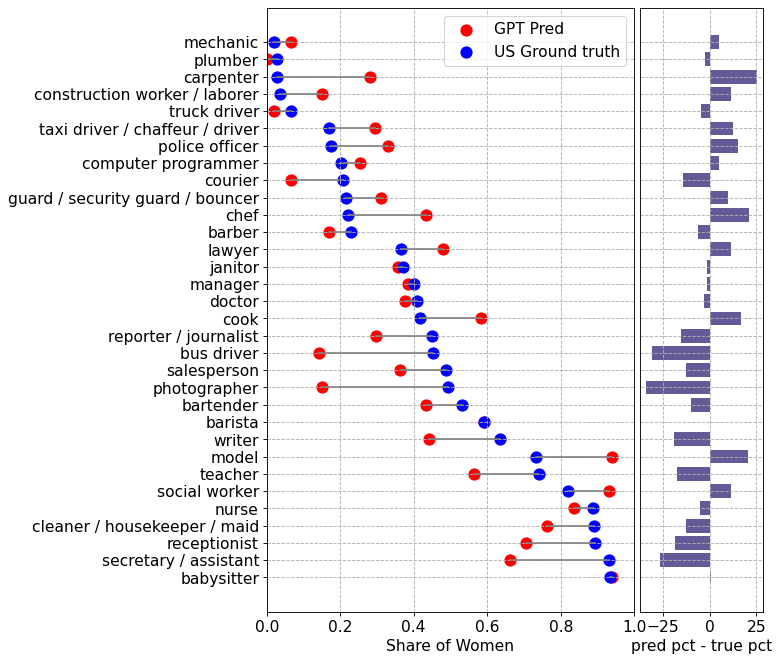

In [ ]:
make_dumbell_and_bar(diff_df, var1='gpt_base_F', var2 ='us_base_F', sort_col = 'us_base_F')

## Scatter Plot

In [ ]:
def scatter_plot_base(diff_df):
  '''Creates a scatter plot for WOMAN comparing US and GPT predictions with subset of jobs labelled.'''
  # Make plot
  fig, ax = plt.subplots(1,1, figsize = (8,8))
  plot_df = diff_df.copy()
  plot_df['share_gpt'] = plot_df['gpt_base_F']/100
  plot_df['share_us'] = plot_df['us_base_F']/100
  xs = plot_df['share_gpt']
  ys = plot_df['share_us']
  sns.scatterplot(x=xs, y=ys, data=diff_df, marker="x", ax = ax, color = 'red')
  ax.set_ylabel("Share of Woman (US 2019 data)", fontsize = 12)
  ax.set_xlabel("Share of Women (GPT pred)", fontsize = 12)
  ax.set_xlim(0,1)
  ax.set_ylim(0,1)
  # Plot x = y line
  x_line = [0, 1]
  y_line = [0, 1]
  ax.plot(x_line, y_line, '--', alpha=0.75, zorder=0, color = 'black')
  # Annotations
  jobs_list = list(plot_df.index)
  together = []
  for i in range(len(jobs_list)):
    label = jobs_list[i]
    x = plot_df['share_gpt'].iloc[i]
    y = plot_df['share_us'].iloc[i]
    together.append((label,x,y))
  together.sort()
  text = [x for (x,y,z) in together]
  xs = [y for (x,y,z) in together]
  ys = [z for (x,y,z) in together]
  texts = []
  for x, y, s in zip(xs, ys, text):
      texts.append(plt.text(x, y, s))
  adjust_text(texts, x=xs, y=ys, autoalign='xy',only_move={'points':'y', 'text':'x'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5),force_text=0.5)
  # fig.savefig(f'./figs/gpt_vs_us_scatter.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

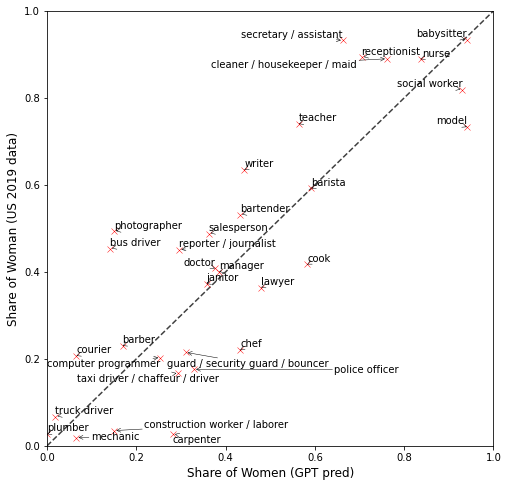

In [ ]:
scatter_plot_base(diff_df)

## Scatter Plot all Ethnicites

In [ ]:
def scatter_plot_eth(diff_df):
  '''Creates a scatter plot for WOMAN + ETH comparing US and GPT predictions with subset of jobs labelled.'''
  # Make plot
  fig, ax = plt.subplots(1,1, figsize = (8,8))
  plot_df = diff_df.copy()

  # Ethnicity
  colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:purple']
  eths = ['asian', 'black', 'hispanic', 'white']
  for col, eth in zip(colors, eths):
    eth_y = (plot_df[f'us_{eth}_F']/(plot_df[f'us_{eth}_M'] + plot_df[f'us_{eth}_F']))
    eth_x = (plot_df[f'gpt_{eth}_F']/(plot_df[f'gpt_{eth}_M'] + plot_df[f'gpt_{eth}_F']))
    #MSE_eth = ((eth_y - eth_x)**2).mean()
    MSE_eth = (((plot_df[f'gpt_{eth}_F']/100) - (plot_df[f'us_{eth}_F']/100))**2).mean()
    if eth == 'hispanic':
      label_eth = f'+{eth.capitalize()}\n[{np.round(MSE_eth,4)}]'
    else:
      label_eth = f'+{eth.capitalize()}\n[{np.round(MSE_eth,4)}]'
    sns.scatterplot(x=eth_x, y=eth_y, data=plot_df, s  = 120, alpha = 0.3, ax = ax, color = col, label = label_eth)

  # Woman
  plot_df['share_gpt'] = plot_df['gpt_base_F']/100
  plot_df['share_us'] = plot_df['us_base_F']/100
  MSE_woman = ((plot_df['share_us'] - plot_df['share_gpt'])**2).mean()
  label_woman = f'Woman\n[{np.round(MSE_woman,4)}]'
  xs = plot_df['share_gpt']
  ys = plot_df['share_us']
  sns.scatterplot(x=xs, y=ys, data=plot_df, s = 120, ax = ax, edgecolor = 'k', color = 'red', label = label_woman)
  ax.set_ylabel("Share of Women (US 2019 data)", fontsize = 16)
  ax.set_xlabel("Share of Women (GPT-2 pred.)", fontsize = 16)
  ax.set_xlim(-0.1,1.1)
  ax.set_ylim(-0.1,1.1)
  ax.legend(fontsize = 16)
  ax.tick_params(axis="x", labelsize=16)
  ax.tick_params(axis="y", labelsize=16)
  # Plot x = y line
  x_line = [0, 1]
  y_line = [0, 1]
  ax.plot(x_line, y_line, '--', alpha=0.5, zorder=0, color = 'black')
  # Annotations
  label_list = ['plumber', 'mechanic', 'carpenter', 'construction worker / laborer',
                'truck driver', 'photographer', 'bus driver', 'cook',
                'model', 'teacher', 'social worker', 'nurse', 'babysitter', 'cleaner / housekeeper / maid',
                'secretary / assistant', 'receptionist', 'guard / security guard / bouncer', 'chef']

  rename_dict= {'guard / security guard / bouncer': 'security guard', 'construction worker / laborer': 'laborer', 'cleaner / housekeeper / maid': 'maid', 'secretary / assistant': 'secretary'}
  jobs_list = list(plot_df.index)
  together = []
  for i in range(len(jobs_list)):
    label = jobs_list[i]
    x = plot_df['share_gpt'].iloc[i]
    y = plot_df['share_us'].iloc[i]
    if label in label_list:
      if label in rename_dict.keys():
        text_label = rename_dict[label]
      else:
        text_label = label
      together.append((text_label,x,y))
  together.sort()

  text = [x for (x,y,z) in together]
  xs = [y for (x,y,z) in together]
  ys = [z for (x,y,z) in together]
  texts = []
  for x, y, s in zip(xs, ys, text):
      texts.append(plt.text(x, y, s, fontsize = 14))
  plt.grid(True,  linestyle = '--')
  handles, labels = ax.get_legend_handles_labels()
  ax.get_legend().remove()
  handles_new = handles[-1:] + handles[:-1]
  labels_new = labels[-1:] + labels[:-1]
  fig.legend(handles_new, labels_new, fontsize = 16, loc = 'lower right', ncol = 1, bbox_to_anchor= (0.98, 0.08))
  adjust_text(texts, x=xs, y=ys, autoalign='xy',only_move={'points':'xy', 'text':'xy'}, arrowprops=dict(arrowstyle="->", color='black', lw=0.5),force_text=0.5)
  plt.tight_layout()
  # fig.savefig(f'./figs/gpt_vs_us_scatter_eth.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

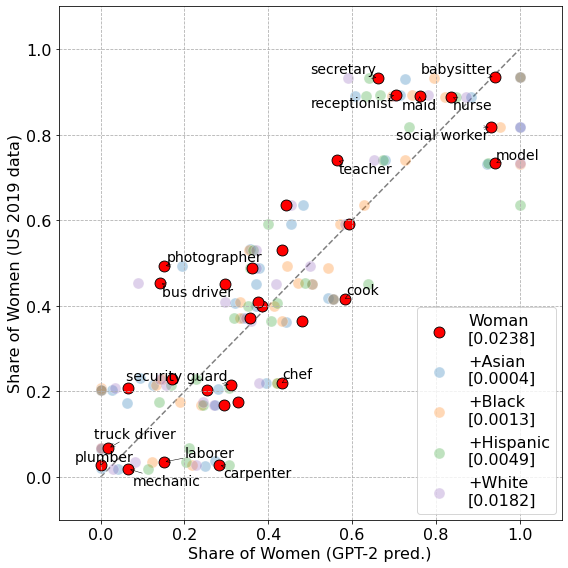

In [ ]:
scatter_plot_eth(diff_df)

## Prediction Heatmap

In [ ]:
def prediction_heatmap(diff_df, by_var):
  ''' Creates a heatmap comparing size of error between US and GPT predictions'''
  sns.set(font_scale=1)
  if by_var == 'eth':
    heatmap_df = diff_df.iloc[:,-10:-2]
    heatmap_df.columns = heatmap_df.columns.str.replace('diff_', '') 
    heatmap_df.columns = heatmap_df.columns.str.replace('_F', '_W') 
    print(heatmap_df.shape)
  elif by_var == 'base':
    heatmap_df = diff_df.iloc[:, -2:]
    heatmap_df.columns = heatmap_df.columns.str.replace('diff_', '') 
    heatmap_df.columns = heatmap_df.columns.str.replace('_F', '_W') 
  elif by_var == 'both':
    heatmap_df = diff_df.iloc[:, -10:]
    heatmap_df.columns = heatmap_df.columns.str.replace('diff_', '')
    heatmap_df.columns = heatmap_df.columns.str.replace('_F', '_W')  
  width = len(heatmap_df.columns)
  fig,ax = plt.subplots(1, figsize = (width,12))
  ax = sns.heatmap(heatmap_df, center=0, cmap="coolwarm", annot=True)
  ax.set_ylabel("")
  ax.set_yticklabels(labels = heatmap_df.index, fontsize = 16)
  ax.set_xticklabels(labels = heatmap_df.columns, fontsize = 16)
  ax.text(x = 8, y = 34, s='GPT < True', color = '#4f69d9', fontsize = 14)
  ax.text(x = 8, y = -0.7, s='GPT > True', color = '#b9142b', fontsize = 14)
  # fig.savefig('./figs/prediction_heatmap.pdf', format='pdf', dpi=600, bbox_inches='tight')
  plt.show()

(33, 8)


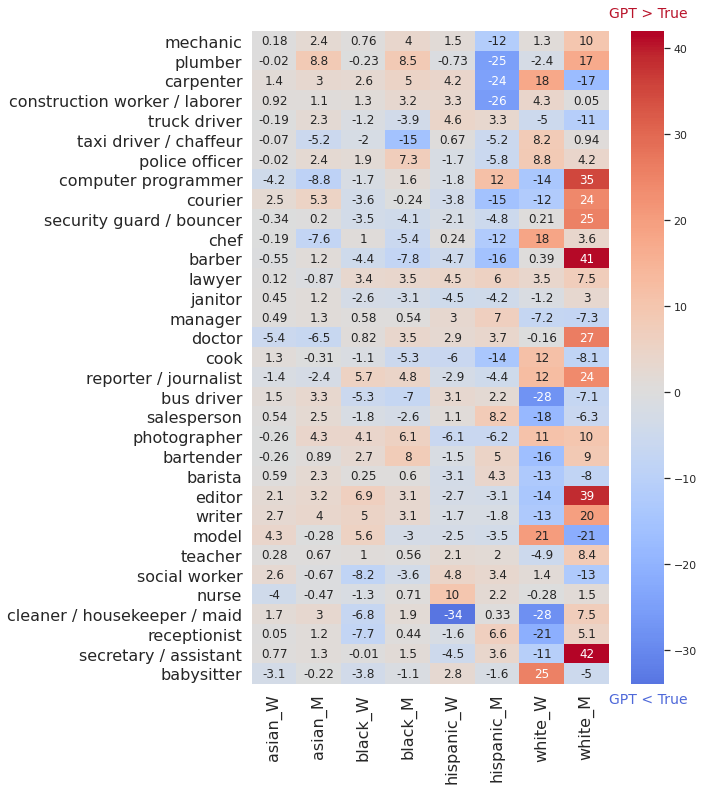

In [ ]:
prediction_heatmap(diff_df, "eth")